# On the properties of variational approximations of Gibbs posteriors

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
np.random.seed(2025)
from scipy.optimize import bisect
from SMC import Tempering_SMC

# Introduction

 The Gibbs posterior (or pseudo-posterior $\hat{\rho _{\lambda}}$) is defined for all $\lambda > 0$ as : 
 
 $$\hat{\rho _{\lambda}} (\theta) \propto \exp\left(-\lambda r_n (\theta)\right) \pi(\theta), $$

where:

- $r_n( \theta )$ is an empirical measure of risk

- $\pi(\theta)$ is the prior.

> Estimators derived from Gibbs posteriors usually show excellent performance in diverse tasks, such as classification, regression, ranking. Usually, we sample from a Gibbs posterior using MCMC, but constructing an efficient MCMC sampler is often difficult. Instead we use VB (Variational Bayes) approximations.

# Framework

We observe a sample $(X_1, Y_1), \dots, (X_n, Y_n)$, taking values in $\mathcal{X} \times \mathcal{Y}$, where the pairs $(X_i, Y_i)$ have the same distribution $P$. We will assume explicitly that the $(X_i, Y_i)$’s are independent. 

A set of predictors is chosen by the statistician: 
$$
\{f_\theta : \mathcal{X} \to \mathbb{R}, \theta \in \Theta\}.
$$
For example, in linear regression, we may have: $f_\theta(x) = \langle \theta, x \rangle$, the inner product of $\mathcal{X} = \mathbb{R}^d$, while in classification, one may have $f_\theta(x) = \mathbb{I}_{\langle \theta, x \rangle > 0} \in \{0, 1\}$.

We assume we have at our disposal a risk function $R(\theta)$; typically $R(\theta)$ is a measure of the prevision error. We set $R = R(\theta)$, where 
$$
\theta \in \arg \min_\Theta R(\theta);
$$ 
i.e. $f_\theta$ is an optimal predictor. We also assume that the risk function $R(\theta)$ has an empirical counterpart $r_n(\theta)$, and set $r_n = r_n(\theta)$. 

Often, $R$ and $r_n$ are based on a loss function $l : \mathbb{R}^2 \to \mathbb{R}$; i.e. 
$$
R(\theta) = \mathbb{E}[l(Y, f_\theta(X))] \quad \text{and} \quad r_n(\theta) = \frac{1}{n} \sum_{i=1}^n l(Y_i, f_\theta(X_i)).
$$
(In this paper, the symbol $\mathbb{E}$ will always denote the expectation with respect to the (unknown) law $P$ of the $(X_i, Y_i)$’s.) There are situations however (e.g. ranking), where $R$ and $r_n$ have a different form.

We define a prior probability measure $\pi(\cdot)$ on the set $\Theta$ (equipped with the standard $\sigma$-algebra for the considered context), and we let $\mathcal{M}_1^+(\Theta)$ denote the set of all probability measures on $\Theta$.


# Assumptions 

## Hoeffding assumption

We say that a **Hoeffding assumption** is satisfied for prior $ \pi $ when there is a function $ f $ and an interval $ I \subset \mathbb{R}_+^* $ such that, for any $ \lambda \in I $, for any $ \theta \in \Theta $,

$$ \frac{\pi \left( \mathbb{E} \exp \{ \lambda [R(\theta) - r_n(\theta)] \} \right)}{\pi \left( \mathbb{E} \exp \{ \lambda [r_n(\theta) - R(\theta)] \} \right)} 
\leq \exp \big[ f(\lambda, n) \big]. \tag{1} $$

$\quad $

## Bernstein assumption

We say that a Bernstein assumption is satisfied for prior $\pi$ when there is a function $g$ and an interval $I \subset \mathbb{R}_+^*$ such that, for any $\lambda \in I$, for any $\theta \in \Theta$,
$$
\frac{\pi \left( \mathbb{E} \exp \left\{ \lambda [R(\theta) - R^*] - \lambda [r_n(\theta) - r_n^*] \right\} \right)}
{\pi \left( \mathbb{E} \exp \left\{ \lambda [r_n(\theta) - r_n^*] - \lambda [R(\theta) - R^*] \right\} \right)} 
\leq \pi \exp \big[ (g(\lambda, n))  [R(\theta) - R^*] \big].
\tag{2}
$$

Assume that **Mammen and Tsybakov’s** margin assumption is satisfied: i.e., there is a constant $C$ such that
$$
\mathbb{E} \left[ \big( \mathbf{1}_{f_\theta(X) \neq Y} - \mathbf{1}_{f_{\theta^*}(X) \neq Y} \big)^2 \right] 
\leq C \big[ R(\theta) - R(\theta^*) \big].
$$

In [2]:
def risk(w, X, y):
    """Loss function: Quadratic loss with L2 regularization."""
    predictions = X @ w
    loss = np.mean((predictions - y) ** 2)
    reg = 0.5 * np.sum(w ** 2)  # L2 regularization
    return loss + reg

def gibbs_posterior(w, X, y, lambda_reg):
    return np.exp(
        -lambda_reg * risk(w, X, y)
        )

def variational_approximation(X, y, lambda_reg):
    def objective(w):
        return risk(w, X, y) + lambda_reg * np.sum(w ** 2)  
    w0 = np.zeros(X.shape[1]) 
    result = minimize(objective, w0, method = 'L-BFGS-B')
    return result.x

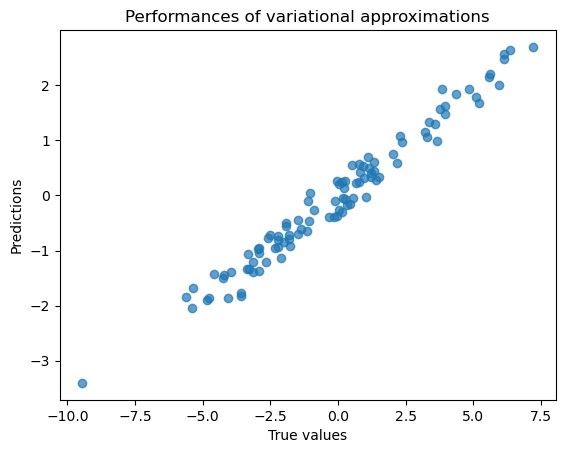

In [3]:
n, d = 100, 10
X = np.random.randn(n, d)
true_w = np.random.randn(d)
y = X @ true_w + 0.1 * np.random.randn(n)
lambda_reg = 1.0

w_gibbs = variational_approximation(X, y, lambda_reg)

# Comparison
predictions = X @ w_gibbs
plt.scatter(y, predictions, alpha = 0.7)
#plt.xscale("log")   
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title("Performances of variational approximations")
plt.show()


# Numerical approximations of the pseudo-posterior

The usual approach to approximate $\hat{\rho}_\lambda$ is MCMC (Markov chain Monte Carlo) sampling. Ridgway et al. [2014] proposed tempering SMC (Sequential Monte Carlo, e.g. Del Moral et al. [2006]) as an alternative to MCMC to sample from Gibbs posteriors: one samples sequentially from $\hat{\rho}_{\lambda_t}$, with $0 = \lambda_0 < \cdots < \lambda_T = \lambda$ where $\lambda$ is the desired temperature. One advantage of this approach is that it makes it possible to contemplate different values of $\lambda$, and choose one by, e.g., cross-validation. Another advantage is that such an algorithm requires little tuning; see Appendix B for more details on the implementation of tempering SMC. We will use tempering SMC as our gold standard in our numerical studies.

SMC and related Monte Carlo algorithms tend to be too slow for practical use in situations where the sample size is large, the dimension of $\Theta$ is large, or $f_\theta$ is expensive to compute. This motivates the use of fast, deterministic approximations, such as Variational Bayes, which we describe in the next section.

---

## Algorithm 1: Tempering SMC
1. **Input**: $N$ (number of particles), $\tau \in (0, 1)$ (ESS threshold), $\kappa > 0$ (random walk tuning parameter)
2. **Initialization**: Sample $\theta_0^i \sim \pi_\xi(\theta)$ for $i = 1$ to $N$, set $t \gets 1$, $\lambda_0 = 0$, $Z_0 = 1$.
3. **Loop**:
   a. Solve in $\lambda_t$ the equation:
   $$
   \frac{\left(\sum_{i=1}^N w_t(\theta_{t-1}^i)\right)^2}{\sum_{i=1}^N w_t(\theta_{t-1}^i)^2} = \tau N, \quad w_t(\theta) = \exp\left[-(\lambda_t - \lambda_{t-1}) r_n(\theta)\right]
   $$
   using bisection search.  
   If $\lambda_t \geq \lambda_T$:
   - Set $Z_T = Z_{t-1} \times \left(\frac{1}{N} \sum_{i=1}^N w_t(\theta_{t-1}^i)\right)$, and stop.

   b. **Resample**: For $i = 1$ to $N$, draw $A_t^i$ in $\{1, \ldots, N\}$ so that:
   $$
   \Pr(A_t^i = j) = \frac{w_t(\theta_{t-1}^j)}{\sum_{k=1}^N w_t(\theta_{t-1}^k)}.
   $$

   c. **Propagate**: $\theta_t^i \gets \text{Perturb}(\theta_{t-1}^{A_t^i})$.

   d. Set:
   $$
   Z_t = Z_{t-1} \times \left(\frac{1}{N} \sum_{i=1}^N w_t(\theta_{t-1}^i)\right).
   $$

---

### Algorithm 2: Systematic Resampling
1. **Input**: Normalized weights $W_j := \frac{w_t(\theta_j)}{\sum_{i=1}^N w_t(\theta_i)}$.
2. **a.** Sample $U \sim \mathcal{U}([0, 1])$.
3. **b.** Compute cumulative weights as $C_n = \sum_{m=1}^n N W_m$.
4. **c.** Set $s \gets U$, $m \gets 1$.
5. **d.** For $n = 1$ to $N$:
   - While $C_m < s$:
     - $m \gets m + 1$.
   - Set $A_n \gets m$, $s \gets s + 1$.

In [ ]:
### First we implement systematic resampling as defined in algorithm 2 of the paper. ###
def systematic_resampling(W):
    """
    Perform systematic resampling given a set of normalized weights.

    Args:
        W (numpy.ndarray): Array of normalized weights.
        W_t (float): Normalized weights of the current time step, size N.

    Returns:
       A (numpy.ndarray) : Indices of resampled particles.
    """
    N = len(W)
    U = np.random.uniform(0, 1)  # Step a: Sample U ~ U([0, 1])
    cumulative_weights = N * np.cumsum(W)  # Step b: Compute cumulative weights

    # Step c: Initialize variables
    s = U
    m = 1
    A = []
    # Step d: Resample
    for n in range(1, N + 1):
        while s > cumulative_weights[m]:
            m += 1
        A.append(m)
        s += 1 
    return np.array(A)


### Next we implement the SMC algorithm as defined in algorithm 1 of the paper. ###
def Tempering_SMC(N, tau, kappa, target_distribution, initial_distribution, likelihood_ratio):
    """ Perform the Tempering Sequential Monte Carlo (SMC) algorithm for Bayesian inference.

    Parameters
    ----------
    N : int
    Number of particles to use in the SMC algorithm.

    tau : float
        ESS threshold for resampling.

    rw : positive
        random walk tuning parameter.

    kappa : float
        Random walk tuning parameter.

    target_distribution : callable
        Target distribution function  pi

    initial_distribution : callable
        Initial distribution function pi_xi

    likelihood_ratio : callable
        Function computing r_n(theta)

    Returns:
    ----------
    list: List of particle states at each iteration. 
    """ 
    
    theta = [initial_distribution() for _ in range(N)]
    t = 1
    lambda_t = 0
    Z = 1
    results = []

    def program_bisec(lambd):
        w = np.exp(- (lambd - lambda_t) * np.array([likelihood_ratio(p) for p in theta]))
        ratio = (np.sum(w) ** 2) / np.sum(w ** 2)
        return ratio - N * tau
    
    while True:
        # Step a: Solve for new lambda_t using bisection 
        lambda_new = bisect(program_bisec, lambda_t, 1)
        w = np.exp(- (lambda_new - lambda_t) * np.array([likelihood_ratio(p) for p in theta]))
        if lambda_new <= lambda_t:
            break 

        # Step b: Resample
        normalized_weights = w / np.sum(w)  
        A = systematic_resampling(normalized_weights)
        theta = [theta[a] for a in A]

        # Step c: MCMC step (Gaussian random-walk Metropolis kernel)
        cov = kappa * np.cov(np.array(theta).T)
        for i in range(N):
            proposal = theta[i] + np.random.multivariate_normal(np.zeros(len(theta[0])), cov)
            accept_ratio = min(1, target_distribution(proposal) / target_distribution(theta[i]))
            if np.random.uniform() < accept_ratio:
                theta[i] = proposal

    
        # Step d: Update normalizing constant Z
        Z *= np.mean(w)
        results.append((theta.copy(), Z))
 
    return results

## Variational Bayes

Variational Bayes (VB) is an approach to approximate $\hat{\rho}_\lambda$ by defining a family $\mathcal{F} \subset \mathcal{M}_1^+(\Theta)$ of tractable probability distributions. The VB approximation $\tilde{\rho}_\lambda$ is defined as:  
$$
\tilde{\rho}_\lambda = \arg\min_{\rho \in \mathcal{F}} K(\rho, \hat{\rho}_\lambda),
$$  
where $K(\rho, \hat{\rho}_\lambda)$ is the Kullback-Leibler (KL) divergence, defined as:  
$$
K(m, \mu) = 
\begin{cases} 
\int \log\left(\frac{dm}{d\mu}\right) dm & \text{if } m \ll \mu, \\
+\infty & \text{otherwise}.
\end{cases}
$$

The choice of $\mathcal{F}$ must balance two criteria:  
(a) $\mathcal{F}$ should be large enough for $\tilde{\rho}_\lambda$ to closely approximate $\hat{\rho}_\lambda$,  
(b) $\mathcal{F}$ should allow efficient computation of $\tilde{\rho}_\lambda$.  


# Application to classification

In all this section, we assume that $ Y = \{0, 1\} $ and we consider linear classification: $ \Theta = X = \mathbb{R}^d $, $ f_\theta(x) = \mathbf{1}_{\langle \theta, x \rangle \geq 0} $. We put 

$$r_n(\theta) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}\{f_\theta(X_i) \neq Y_i\}, \quad R(\theta) = \mathbb{P}(Y \neq f_\theta(X)), $$

and assume that the $(X_i, Y_i)_{i=1}^n $ are i.i.d.
In this setting, it is well-known that the Hoeffding assumption always holds. That's to say:


## Hoeffding assumption

We say that a **Hoeffding assumption** is satisfied for prior $ \pi $ when there is a function $ f $ and an interval $ I \subset \mathbb{R}_+^* $ such that, for any $ \lambda \in I $, for any $ \theta \in \Theta $,

$$ \frac{\pi \left( \mathbb{E} \exp \{ \lambda [R(\theta) - r_n(\theta)] \} \right)}{\pi \left( \mathbb{E} \exp \{ \lambda [r_n(\theta) - R(\theta)] \} \right)} 
\leq \exp \big[ f(\lambda, n) \big]. \tag{1} $$

Here, Hoeffding assumption is satisfied with $f(\lambda, n) = \frac{\lambda^2}{2n}$.

## Bernstein assumption

We say that a Bernstein assumption is satisfied for prior $\pi$ when there is a function $g$ and an interval $I \subset \mathbb{R}_+^*$ such that, for any $\lambda \in I$, for any $\theta \in \Theta$,
$$
\frac{\pi \left( \mathbb{E} \exp \left\{ \lambda [R(\theta) - R^*] - \lambda [r_n(\theta) - r_n^*] \right\} \right)}
{\pi \left( \mathbb{E} \exp \left\{ \lambda [r_n(\theta) - r_n^*] - \lambda [R(\theta) - R^*] \right\} \right)} 
\leq \pi \exp \big[ (g(\lambda, n))  [R(\theta) - R^*] \big].
\tag{2}
$$

Assume that **Mammen and Tsybakov’s** margin assumption is satisfied: i.e., there is a constant $C$ such that
$$
\mathbb{E} \left[ \big( \mathbf{1}_{f_\theta(X) \neq Y} - \mathbf{1}_{f_{\theta^*}(X) \neq Y} \big)^2 \right] 
\leq C \big[ R(\theta) - R(\theta^*) \big].
$$
Then Bernstein assumption is satisfied with 
$$
g(\lambda, n) = \frac{C \lambda^2}{2n - \lambda}.
$$

## The prior 

Gaussian prior : $ \pi = \mathcal{N}_d (0, v^2 \text{I}_d )$.

## Three sets of Variational Gaussian approximations:  
Consider the three following Gaussian families 
$$
\mathcal{F}_1 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in \mathbb{R}_+^* \},
$$
$$
\mathcal{F}_2 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in (\mathbb{R}_+^*)^d \},
$$
$$
\mathcal{F}_3 = \{ \Phi_{m, \Sigma} \mid m \in \mathbb{R}^d, \Sigma \in \mathcal{S}_d^+ \},
$$
where $\Phi_{m, \sigma^2}$ is a Gaussian distribution $\mathcal{N}_d(m, \sigma^2 I_d)$, $\Phi_{m, \sigma^2}$ is $\mathcal{N}_d(m, \text{diag}(\sigma^2))$, and $\Phi_{m, \Sigma}$ is $\mathcal{N}_d(m, \Sigma)$. 

Obviously, $\mathcal{F}_1 \subset \mathcal{F}_2 \subset \mathcal{F}_3 \subset \mathcal{M}_1^+(\Theta)$, and
$$
B_\lambda(\mathcal{M}_1^+(\Theta)) \leq B_\lambda(\mathcal{F}_3) \leq B_\lambda(\mathcal{F}_2) \leq B_\lambda(\mathcal{F}_1).
$$


In [ ]:
def L_F2(lamb, v):
    """ As defined page 11 (section 5.4)
    Return a function depending on m, sigma 
    """
    


def L_F3():
    """ As defined page 11 (section 5.4)"""

In [15]:
DATASET = ['pima-indians-diabetes',
           'glass',
           'credit',
           'dna',
           'spectf',
           #'indian',
           'breast-cancer']

DATASET_DOWNLOAD = [fetch_openml(name = dataset, 
                                 version=1) 
                                 for dataset in DATASET]

## Support Vector Machine

In [19]:
# SVM 
def preprocess_data(X):
    label_encoder = LabelEncoder()
    for col in X.columns:  # If X is a pandas dataframe
        if X[col].dtype == 'category':  # Only encode string columns
            X[col] = label_encoder.fit_transform(X[col])
    return X

def train_svm(X, y, kernel = 'rbf', gamma = 'scale'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    X_train = preprocess_data(X_train)
    X_test = preprocess_data(X_test)
    svm = SVC(kernel = kernel, gamma = gamma)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    misclassification_rate = np.mean(y_pred != y_test)
    return misclassification_rate

for i, dataset in enumerate(DATASET_DOWNLOAD):
    X, y = dataset['data'], dataset['target']
    print(f"Accuracy for {DATASET[i]} with SVM: {train_svm(X, y)}")

Accuracy for pima-indians-diabetes with SVM: 0.2510822510822511
Accuracy for glass with SVM: 0.676923076923077
Accuracy for credit with SVM: 0.44526420737786643
Accuracy for dna with SVM: 0.036610878661087864
Accuracy for spectf with SVM: 0.13333333333333333
Accuracy for breast-cancer with SVM: 0.3023255813953488


In [26]:
len(DATASET_DOWNLOAD[3]['data'].columns)

180

In [2]:
t = 0
condition = False 
while True:
    t += 1
    if t == 3:
        break
    print("Hello")

Hello
Hello
